# 챕터2 텐서플로 동작 방식

## 1. 계산 그래프의 연산
- 텐서 그래프를 구성하고 session.run 을 통해 feed를 흘려주면 결과가 나온다

In [2]:
import tensorflow as tf
sess = tf.Session()

In [5]:
import numpy as np
x_vals = np.array([1., 3.])

x_data = tf.placeholder(tf.float32)

m_const = tf.constant(3.)
my_product = tf.multiply(x_data, m_const)

for x_val in x_vals:
    print(sess.run(my_product, feed_dict={x_data: x_val}))

3.0
9.0


## 2. 다중 연산 중첩
- matrix 연산을 통해 data의 shape이 변경되는 것도 문제없다

In [6]:
my_array = np.array([[1., 3.], [2., 4.], [3., 5.]])
# 3 x 2
x_vals = np.array([my_array, my_array + 1])
# 2 x [3 x 2]
x_data = tf.placeholder(tf.float32, shape=(3, 2))

m1 = tf.constant([[1.], [0.]])
# 2 x 1
m2 = tf.constant([[2.]])
# 1 x 1
a1 = tf.constant([[10.]])
# 1 x 1
# graph
prod1 = tf.matmul(x_data, m1)
# 3 x 2 * 2 x 1 = 3 x 1
prod2 = tf.matmul(prod1, m2)
# 3 x 1 * 1 x 1 = 3 x 1
add1 = tf.add(prod2, a1)
# 3 x 1 + 1 x 1

for x_val in x_vals:
    print(sess.run(add1, feed_dict={x_data: x_val}))

[[12.]
 [14.]
 [16.]]
[[14.]
 [16.]
 [18.]]


- 텐서보드(tensorboard)를 통해 그래프를 시각화 할 수 도 있음

## 3. 다층 처리
- 그래프는 쌓을수록 비약적으로 복잡해지기에 디버깅을 위한 설정들이 필요함
- 연산에 이름을 붙이고 계층 스코프를 설정이 필요해짐
- 아래는`이미지` 데이터를 cnn층으로 연산하는 간단한 예제임

In [7]:
x_shape = [1,4,4,1]
x_val = np.random.uniform(size=x_shape) # uniform 균일한 랜덤 값을 생성

x_data = tf.placeholder(tf.float32, shape=x_shape)

my_filter = tf.constant(0.25, shape=[2,2,1,1])
my_strides = [1,2,2,1]

mov_avg_layer = tf.nn.conv2d(x_data, my_filter, my_strides, padding='SAME', name='Moving_Avg_Window')
# name값을 사용하면 tensor에 name이 지정됨
# (공식) aft_width = (prv_width - filter + 2 * padding_size) / strides + 1

In [9]:
def custom_layer(input_matrix):
    input_matrix_sqeezed = tf.squeeze(input_matrix)
    # squeeze는 빈 차원을 제거해줌 ( [1 x 1 x 1] -> [1])
    A = tf.constant([[1., 2.], [-1., 3.]])
    b = tf.constant(1., shape=[2, 2])
    temp1 = tf.matmul(A, input_matrix_sqeezed)
    temp = tf.add(temp1, b)
    return tf.sigmoid(temp)

with tf.name_scope('Custom_Layer') as scope:
    custom_layer1 = custom_layer(mov_avg_layer)
# 텐서보드의 그래프 시각화에서 스코프 단위로 관리하게 해줌

print(sess.run(custom_layer1, feed_dict={x_data:x_val}))
# p.73 [그림3] 참고

[[0.93235743 0.9128583 ]
 [0.9324397  0.8449711 ]]


## 4. 비용 함수(손실 함수) 구현
- 모델의 예측 값과 라벨(정답) 값의 거리(손실 함수)를 정의할 수 있음
- 손실 함수로 계산된 loss를 줄이는 방향으로 모델을 최적화 할 수 있음

In [10]:
import matplotlib.pyplot as plt

In [11]:
x_vals = tf.linspace(-1., 1., 500) # (-1 ~ 0 ~ 1)
target = tf.constant(0.)

In [14]:
# L2 norm
l2_y_vals = tf.square(target - x_vals)
l2_y_out = sess.run(l2_y_vals)
## nn.l2_loss() 는 위 l2 norm / 2 를 뱉어냄

In [15]:
# L1 norm
l1_y_vals = tf.abs(target - x_vals)
l1_y_out = sess.run(l1_y_vals)

In [16]:
# pseido-huber
# - l1와 l2의 장점만을 취했다고 함
delta1 = tf.constant(0.25)
phuber1_y_vals = tf.multiply(tf.square(delta1), tf.sqrt(1. + tf.square((target - x_vals) / delta1)) - 1.)
phuber1_y_out = sess.run(phuber1_y_vals)

In [17]:
x_vals = tf.linspace(-3., 5., 500)
target = tf.constant(1.)
targets = tf.fill([500,], 1.)

# Hinge
# - 
hinge_y_vals = tf.maximum(0., 1. - tf.multiply(target, x_vals))
hinge_y_out = sess.run(hinge_y_vals)

In [18]:
# cross-entropy
# - logistic function
# - (0, 1) 두개를 분류할 때 사용함
xentropy_y_vals = - tf.multiply(target, tf.log(x_vals)) - tf.multiply((1. - target), tf.log(1. - x_vals))
xentropy_y_out = sess.run(xentropy_y_vals)

In [19]:
# sigmoid-cross-entropy
# - cross-entropy를 통과하기 전에 sigmoid 결과 값을 사용함
x_val_input = tf.expand_dims(x_vals, 1)
target_input = tf.expand_dims(targets, 1)
xentropy_sigmoid_y_vals = tf.nn.sigmoid_cross_entropy_with_logits(labels=target_input, logits=x_val_input)
xentropy_sigmoid_y_out = sess.run(xentropy_sigmoid_y_vals)

In [22]:
# weighted-cross-entropy
# - sigmoid-cross-entropy에 weight를 더함
weight = tf.constant(0.5)
xentropy_weighted_y_vals = tf.nn.weighted_cross_entropy_with_logits(targets, x_vals, weight)
xentropy_weighted_y_out = sess.run(xentropy_weighted_y_vals)

In [25]:
# softmax-corss-entropy
# - softmax 함수(확률의 총 합이 1)를 통해 여럿 분류의 확률을 계산 함
unscaled_logits = tf.constant([[1., -3., 10.]])
target_dist = tf.constant([[0.1, 0.02, 0.88]])
softmax_xentropy = tf.nn.softmax_cross_entropy_with_logits(logits=unscaled_logits, labels=target_dist)
print(sess.run(softmax_xentropy))

[1.1601256]


In [29]:
# sparse-softmax-cross-entropy
# - 한 타겟만을 대상으로 [0., 0., 1.] softmax 하고 계산 함
unscaled_logits = tf.constant([[1., -3., 10.]])
sparse_target_dist = tf.constant([2])
sparse_xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=unscaled_logits, labels=sparse_target_dist)
print(sess.run(sparse_xentropy))

[0.00012564]


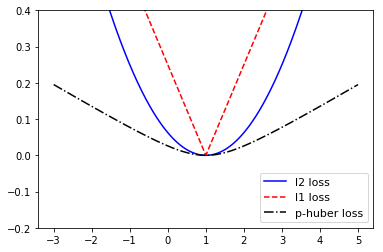

In [30]:
x_array = sess.run(x_vals)
plt.plot(x_array, l2_y_out, 'b-', label='l2 loss')
plt.plot(x_array, l1_y_out, 'r--', label='l1 loss')
plt.plot(x_array, phuber1_y_out, 'k-.', label='p-huber loss')
plt.ylim(-0.2, 0.4)
plt.legend(loc='lower right', prop={'size': 11})
plt.show()

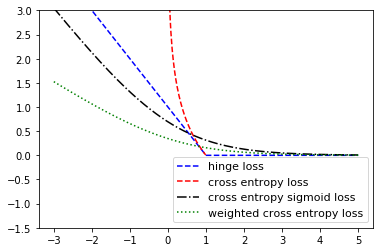

In [31]:
x_array = sess.run(x_vals)
plt.plot(x_array, hinge_y_out, 'b--', label='hinge loss')
plt.plot(x_array, xentropy_y_out, 'r--', label='cross entropy loss')
plt.plot(x_array, xentropy_sigmoid_y_out, 'k-.', label='cross entropy sigmoid loss')
plt.plot(x_array, xentropy_weighted_y_out, 'g:', label='weighted cross entropy loss')
plt.ylim(-1.5, 3)
plt.legend(loc='lower right', prop={'size': 11})
plt.show()

- 다양한 loss 함수들은 학습의 목적, 방향에 따라 적절하게 사용해야 함
- p.82 [표 1] 참고

## 5. 역전파 구현
- loss의 오차를 가지고 역전파(거꾸로) tensor의 값들을 업데이트 해줘야 한다 (loss를 줄이는 방향으로)
- 이 때 필요한 파라미터로 학습률(learning_rate), 최적화 방식(optimizer)가 필요하다

최적화 알고리즘은 여러가지가 존재하는데 모든 알고리즘은 distance(step by step)에 영향을 많이 받는다.
가령, 내가 너무 빨리 다음 스템으로 나아가면 optimal 값을 놓치는 경우가 있고 너무 천천히 가면 학습이 느리거나 optimal 하지 않은 지점에서 수렴할 수 도 있다.
이런 문제를 통컬어 (vanishing and exploding gradient problem)라 하는데 여러가지 해결책들이 존재하고 이 책의 마지막 챕터에서 자세하게 알아본다.

- tf.train.GradientDescentOptimizer
    - 일반적임
- tf.train.MomentumOptimizer
    - 이전 단계의 일정 비율, 운동량을 반영함
- tf.train.AdagradOptimizer
    - 변화가 작은 곳엔 큰 학습률, 반대의 경우에는 작은 학습률을 반영함
- tf.train.AdadeltaOptimizer
    - Adagrad 방식이 너무 빨리 수렴하는 것을 방지하고자 step에 제한을 두고 학습률을 반영함

## 6. 일괄 학습과 확률적 학습
- data_set이 하나만 있으면 발생하는 문제가 현재 data에 의존하여 학습하게 됨
- train도 잘 안되지만 test에는 처참한 결과가 나올 수 있음

위 문제로 batch_size(data_set 뭉텅이)를 지정하여 한번에 계산하고 그 결과에 avg만 큼만 역전파 시키게 한다.
그리고 batch_size는 변수이기에 `placeholder`의 shape의 첫번째 차원은 `None`으로 두고 진행한다.

Step #5 A = [2.1466115]
Loss = [61.29118]
Step #10 A = [3.598931]
Loss = [42.60878]
Step #15 A = [4.772729]
Loss = [20.388746]
Step #20 A = [5.7235684]
Loss = [12.682028]
Step #25 A = [6.507857]
Loss = [17.224955]
Step #30 A = [7.214796]
Loss = [15.156887]
Step #35 A = [7.7399178]
Loss = [2.9356117]
Step #40 A = [8.041112]
Loss = [2.8013623]
Step #45 A = [8.425943]
Loss = [4.1367464]
Step #50 A = [8.709001]
Loss = [0.29369766]
Step #55 A = [8.943162]
Loss = [0.00369033]
Step #60 A = [9.135042]
Loss = [3.1998165]
Step #65 A = [9.265389]
Loss = [0.23138848]
Step #70 A = [9.291482]
Loss = [0.36289358]
Step #75 A = [9.376638]
Loss = [4.5032854]
Step #80 A = [9.515373]
Loss = [5.289356]
Step #85 A = [9.647591]
Loss = [0.6921221]
Step #90 A = [9.7754135]
Loss = [0.9752131]
Step #95 A = [9.807905]
Loss = [0.01553097]
Step #100 A = [9.881546]
Loss = [2.175944]
Step #5 A = [[1.0692612]]
Loss = 80.02527
Step #10 A = [[2.722555]]
Loss = 52.49311
Step #15 A = [[4.079996]]
Loss = 32.94787
Step #20 

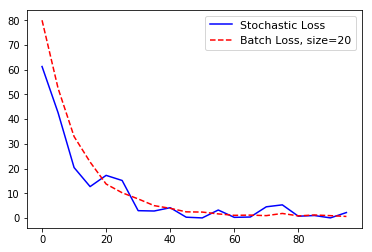

In [34]:
# Create data
x_vals = np.random.normal(1, 0.1, 100)
y_vals = np.repeat(10., 100)
x_data = tf.placeholder(shape=[1], dtype=tf.float32)
y_target = tf.placeholder(shape=[1], dtype=tf.float32)

# Create variable (one model parameter = A)
A = tf.Variable(tf.random_normal(shape=[1]))

# Add operation to graph
my_output = tf.multiply(x_data, A)

# Add L2 loss operation to graph
loss = tf.square(my_output - y_target)

# Initialize variables
init = tf.initialize_all_variables()
sess.run(init)

# Create Optimizer
my_opt = tf.train.GradientDescentOptimizer(0.02)
train_step = my_opt.minimize(loss)

loss_stochastic = []
# Run Loop
for i in range(100):
    rand_index = np.random.choice(100)
    rand_x = [x_vals[rand_index]]
    rand_y = [y_vals[rand_index]]
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    if (i+1)%5==0:
        print('Step #' + str(i+1) + ' A = ' + str(sess.run(A)))
        temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
        print('Loss = ' + str(temp_loss))
        loss_stochastic.append(temp_loss)
        

# Batch Training:
sess = tf.Session()

# Declare batch size
batch_size = 20

# Create data
x_vals = np.random.normal(1, 0.1, 100)
y_vals = np.repeat(10., 100)
x_data = tf.placeholder(shape=[None, 1], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

# Create variable (one model parameter = A)
A = tf.Variable(tf.random_normal(shape=[1,1]))

# Add operation to graph
my_output = tf.matmul(x_data, A)

# Add L2 loss operation to graph
loss = tf.reduce_mean(tf.square(my_output - y_target))

# Initialize variables
init = tf.initialize_all_variables()
sess.run(init)

# Create Optimizer
my_opt = tf.train.GradientDescentOptimizer(0.02)
train_step = my_opt.minimize(loss)

loss_batch = []
# Run Loop
for i in range(100):
    rand_index = np.random.choice(100, size=batch_size)
    rand_x = np.transpose([x_vals[rand_index]])
    rand_y = np.transpose([y_vals[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    if (i+1)%5==0:
        print('Step #' + str(i+1) + ' A = ' + str(sess.run(A)))
        temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
        print('Loss = ' + str(temp_loss))
        loss_batch.append(temp_loss)
        
plt.plot(range(0, 100, 5), loss_stochastic, 'b-', label='Stochastic Loss')
plt.plot(range(0, 100, 5), loss_batch, 'r--', label='Batch Loss, size=20')
plt.legend(loc='upper right', prop={'size': 11})
plt.show()

## 8. 모델 평가
- training도 중요하지만 testing이 더 중요하다

test를 통한 모델 평가가 이뤄지지 않은다면 train_data_set에 optimal한 model을 얻을 뿐
훈련되지 않는 real data에는 성능이 나쁠 수 있기 때문이다.